In [88]:
import torch
from sbi import utils as sbi_utils
from sbi import analysis as analysis
from sbi.inference.base import infer

import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import gridspec

In [ ]:
import szfastmap as szfm
import numpy as np
from pixell import enmap, utils, bunch, pointsrcs
from enlib import clusters
import time

dtype   = np.float32

inputdir = "/Users/anirbanroy/Documents/SZfastMap/input/"
#mapfile = inputdir + "cmb_daynight_tot_f150_coadd.zip" #"fullsky_actbeam_f150.zip"
#mapfile = inputdir + "fullsky_actbeam_f090.zip"
geometry = inputdir + 'my_geometry.fits'

beam = inputdir + "cmb_daynight_tot_f150_coadd/beam.txt"
freq = 150 * 1e9

ofile = "Test_ymap3.fits"

start = time.time()

cosmo = szfm.cosmology.cosmology()

Cosmo4enlib = {'Omega_m':cosmo.omegam,'h':cosmo.h,'Omega_b':cosmo.omegab}

hmf = szfm.hmf.hmf(cosmo)

lc = szfm.lightcone.lightcone(cosmo=cosmo,fsky=0.01,Mmin=2e14)

lc.populate(hmf.dndmofmz)

# write halos in pksc halo format used in Websky
catfile = 'test_cat.pksc'
lc.write_pksc(catfile=catfile)

#bsize   = 100000.
margin  = 100
beta_range = [-14,-3]
vmin    = 0.001

print ("nhalo start",time.time() - start)
nhalo   = clusters.websky_pkcs_nhalo(catfile)
print ("nhalo = ",nhalo)
prof_builder= clusters.ProfileBattagliaFast(cosmology=Cosmo4enlib, beta_range=beta_range)
mass_interp = clusters.MdeltaTranslator(Cosmo4enlib)
print ("websky read",time.time() - start)
data  = clusters.websky_pkcs_read(catfile)

#meta        = mapdata.read_meta(mapfile)
shape, wcs  = enmap.read_map_geometry(geometry)
omap        = enmap.zeros(shape[-2:], wcs, dtype)
rht         = utils.RadialFourierTransform()
#lbeam       = np.interp(rht.l, np.arange(len(meta.beam)), meta.beam)
# Read the beam from one of the two formats
try:
	sigma = float(beam)*utils.fwhm*utils.arcmin
	lbeam = np.exp(-0.5*rht.l**2*sigma**2)
except ValueError:
	l, bl = np.loadtxt(beam, usecols=(0,1), ndmin=2).T
	lbeam = np.interp(rht.l, l, bl)

#fullsky = enmap.area(shape, wcs)/(4*np.pi) > 0.8

#if not fullsky:
#	pixs  = enmap.sky2pix(shape, wcs, utils.rect2ang(data.T[:3])[::-1])
#	good  = np.all((pixs >= -margin) & (pixs < np.array(shape[-2:])[:,None]+margin), 0)
#	data  = data[good]

print ("cat",time.time() - start)

cat    = clusters.websky_decode(data, Cosmo4enlib, mass_interp); del data

print ("prof builder",time.time() - start)

rprofs  = prof_builder.y(cat.m200[:,None], cat.z[:,None], rht.r)
lprofs  = rht.real2harm(rprofs)
lprofs  *= lbeam
rprofs  = rht.harm2real(lprofs)
r, rprofs = rht.unpad(rht.r, rprofs)
# and factor out peak value
yamps   = rprofs[:,0].copy()
rprofs /= yamps[:,None]
# Prepare for painting
#amps   = (yamps * utils.tsz_spectrum(meta.freq*1e9) / utils.dplanck(meta.freq*1e9) * 1e6).astype(dtype)
amps   = (yamps * utils.tsz_spectrum(freq) / utils.dplanck(freq) * 1e6).astype(dtype)
poss   = np.array([cat.dec,cat.ra]).astype(dtype)
profiles = [np.array([r,prof]).astype(dtype) for prof in rprofs]; del rprofs
prof_ids = np.arange(len(profiles)).astype(np.int32)

print ("sim obs",time.time() - start)

pointsrcs.sim_objects(shape, wcs, poss, amps, profiles, prof_ids=prof_ids, omap=omap, vmin=vmin)

print ("write map",time.time() - start)

enmap.write_map(ofile, omap)

print ("end",time.time() - start)

#print (poss)


In [8]:
import matplotlib.pyplot as plt

from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)


In [9]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

image_file = get_pkg_data_filename('/Users/anirbanroy/Documents/SZfastMap/Test_ymap3.fits')
image_data = fits.getdata(image_file, ext=0)

bins=30
delta_f = image_data.flatten()
hist, bine = np.histogram(delta_f, bins=bins, density = True)

In [10]:
fits.info(image_file)

Filename: /Users/anirbanroy/Documents/SZfastMap/Test_ymap3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (2400, 2400)   float32   


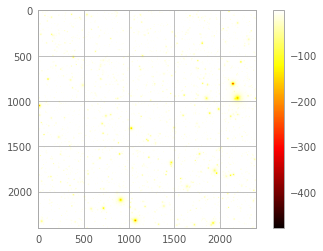

In [11]:
plt.figure()
plt.imshow(image_data, cmap='hot')
plt.colorbar()

In [12]:
import numpy as np

In [13]:
bins=30
delta_f = image_data.flatten()
hist, bine = np.histogram(delta_f, bins=bins, density = True)

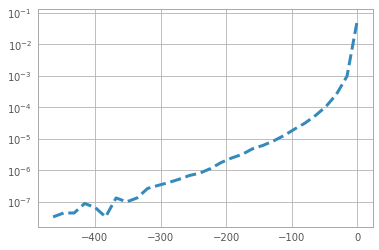

In [14]:
plt.plot(bine[1:], hist,linestyle='--', lw=3)
plt.yscale("log")

In [15]:
image_file = get_pkg_data_filename('/Users/anirbanroy/Documents/SZfastMap/Test_ymap4.fits')
image_data = fits.getdata(image_file, ext=0)

bins=30
delta_f = image_data.flatten()
hist1, bine1 = np.histogram(delta_f, bins=bins, density = True)

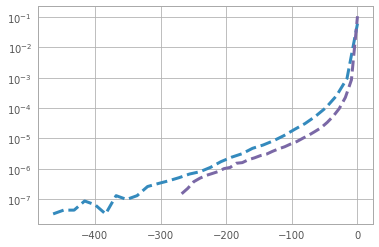

In [16]:
plt.plot(bine[1:], hist,linestyle='--', lw=3)
plt.plot(bine1[1:], hist1, linestyle='--', lw=3)
plt.yscale("log")

In [1]:
plt.plot(bine[1:], hist, linestyle='--', lw=3)
plt.plot(bine[1:], hist1, linestyle='--', lw=3)
plt.yscale("log")

NameError: name 'plt' is not defined

In [92]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import gridspec

import szfastmap as szfm
import numpy as np
from pixell import enmap, utils, bunch, pointsrcs
from enlib import clusters
import time


def cal_sz_prosterior(parameter_set, bins_num =30):

    dtype   = np.float32
    
    parameter_set = parameter_set.numpy()

    omega_b = parameter_set[0]
    h = parameter_set[1]
    sigma8 = parameter_set[2]

    cosmo = szfm.cosmology.cosmology(Omega_b=omega_b, h=h, sigma8= sigma8)
    Cosmo4enlib = {'Omega_b': omega_b, 'h': h, 'sigma8': sigma8}

    hmf = szfm.hmf.hmf(cosmo)
    lc = szfm.lightcone.lightcone(cosmo=cosmo,fsky=0.01,Mmin=2e14)

    inputdir = "/Users/anirbanroy/Documents/SZfastMap/input/"
    #mapfile = inputdir + "cmb_daynight_tot_f150_coadd.zip" #"fullsky_actbeam_f150.zip"
    #mapfile = inputdir + "fullsky_actbeam_f090.zip"
    geometry = inputdir + 'my_geometry.fits'

    beam = inputdir + "cmb_daynight_tot_f150_coadd/beam.txt"
    freq = 150 * 1e9

    ofile = "Test_ymap3.fits"

    start = time.time()

    cosmo = szfm.cosmology.cosmology()

    Cosmo4enlib = {'Omega_m':cosmo.omegam,'h':cosmo.h,'Omega_b':cosmo.omegab}

    hmf = szfm.hmf.hmf(cosmo)

    lc = szfm.lightcone.lightcone(cosmo=cosmo, fsky=0.01, Mmin=2e14)

    lc.populate(hmf.dndmofmz)

    # write halos in pksc halo format used in Websky
    catfile = 'test_cat.pksc'
    lc.write_pksc(catfile=catfile)

    #bsize   = 100000.
    margin  = 100
    beta_range = [-14,-3]
    vmin    = 0.001

    print ("nhalo start",time.time() - start)
    nhalo   = clusters.websky_pkcs_nhalo(catfile)
    print ("nhalo = ",nhalo)
    prof_builder= clusters.ProfileBattagliaFast(cosmology=Cosmo4enlib, beta_range=beta_range)
    mass_interp = clusters.MdeltaTranslator(Cosmo4enlib)
    print ("websky read",time.time() - start)
    data  = clusters.websky_pkcs_read(catfile)

    #meta        = mapdata.read_meta(mapfile)
    shape, wcs  = enmap.read_map_geometry(geometry)
    omap        = enmap.zeros(shape[-2:], wcs, dtype)
    rht         = utils.RadialFourierTransform()
    #lbeam       = np.interp(rht.l, np.arange(len(meta.beam)), meta.beam)
    # Read the beam from one of the two formats
    try:
        sigma = float(beam)*utils.fwhm*utils.arcmin
        lbeam = np.exp(-0.5*rht.l**2*sigma**2)
    except ValueError:
        l, bl = np.loadtxt(beam, usecols=(0,1), ndmin=2).T
        lbeam = np.interp(rht.l, l, bl)

    #fullsky = enmap.area(shape, wcs)/(4*np.pi) > 0.8

    #if not fullsky:
    #	pixs  = enmap.sky2pix(shape, wcs, utils.rect2ang(data.T[:3])[::-1])
    #	good  = np.all((pixs >= -margin) & (pixs < np.array(shape[-2:])[:,None]+margin), 0)
    #	data  = data[good]

    print ("cat",time.time() - start)

    cat    = clusters.websky_decode(data, Cosmo4enlib, mass_interp); del data

    print ("prof builder",time.time() - start)

    rprofs  = prof_builder.y(cat.m200[:,None], cat.z[:,None], rht.r)
    lprofs  = rht.real2harm(rprofs)
    lprofs  *= lbeam
    rprofs  = rht.harm2real(lprofs)
    r, rprofs = rht.unpad(rht.r, rprofs)
    # and factor out peak value
    yamps   = rprofs[:,0].copy()
    rprofs /= yamps[:,None]
    # Prepare for painting
    #amps   = (yamps * utils.tsz_spectrum(meta.freq*1e9) / utils.dplanck(meta.freq*1e9) * 1e6).astype(dtype)
    amps   = (yamps * utils.tsz_spectrum(freq) / utils.dplanck(freq) * 1e6).astype(dtype)
    poss   = np.array([cat.dec,cat.ra]).astype(dtype)
    profiles = [np.array([r,prof]).astype(dtype) for prof in rprofs]; del rprofs
    prof_ids = np.arange(len(profiles)).astype(np.int32)

    print ("sim obs",time.time() - start)

    pointsrcs.sim_objects(shape, wcs, poss, amps, profiles, prof_ids=prof_ids, omap=omap, vmin=vmin)

    #print ("write map",time.time() - start)

    #enmap.write_map(ofile, omap)

    print ("end",time.time() - start)
    
    #image_data = fits.getdata(omap, ext=0)

    delta_f = omap.flatten()
    
    hist, bine = np.histogram(delta_f, bins = bins_num, density = True)
    
    return torch.tensor(hist)


bins=30
num_dim = 3
prior = sbi_utils.BoxUniform(low= torch.tensor([0.01, 0.5, 0.5]), high= torch.tensor([0.07, 0.9, 1.0]))
posterior = infer(cal_sz_prosterior, prior, method="SNPE", num_simulations=200)


parameter_set1 = torch.tensor([0.04, 0.6, 0.7])
parameter_set1 = torch.tensor([0.04, 0.6, 0.8])
parameter_set1 = torch.tensor([0.04, 0.7, 0.8])

observation1 = cal_sz_prosterior(parameter_set1, bins_num = bins)
observation2 = cal_sz_prosterior(parameter_set2, bins_num = bins)
observation3 = cal_sz_prosterior(parameter_set3, bins_num = bins)

np.shape("posterior_tSZ.npz", posterior=posterior,
         observation1= observation1, observation2= observation2,
         observation3= observation3)


 populating catalog with halos
   z, Nshell, Ntot, Mmin, Mmax:  2.05         8      4366 2.030716e+14 4.344133e+14
 writing 4366 halos to file test_cat.pksc
   start_index, end_index:  0 4366
nhalo start 0.08780980110168457
nhalo =  4366
websky read 0.9139420986175537
cat 1.0826029777526855


KeyboardInterrupt: 

In [78]:
cosmo = szfm.cosmology.cosmology()

Cosmo4enlib = {'Omega_m':cosmo.omegam, 'Sigma_8':0.9 ,'Omega_b':cosmo.omegab}

In [81]:
cosmo.sigma8
cosmo.omegab

0.049

In [82]:
Cosmo4enlib 

{'Omega_m': 0.31, 'Sigma_8': 0.9, 'Omega_b': 0.049}

In [83]:
cosmo = szfm.cosmology.cosmology(Omega_b=cosmo.omegab, h=0.5, sigma8= 0.7)
Cosmo4enlib = {'Omega_b': 0.1, 'h': 0.5, sigma8 =0.5}

SyntaxError: invalid syntax (3319663670.py, line 2)

In [89]:
num_dim = 3
prior = sbi_utils.BoxUniform(low= torch.tensor([0.01, 0.5, 0.5]), high= torch.tensor([0.07, 0.9, 1.0]))
bins=40

In [90]:
prior

BoxUniform(Uniform(low: torch.Size([3]), high: torch.Size([3])), 1)

In [56]:
parameter_set = parameter_set.numpy()

omega_b = parameter_set[0]
h = parameter_set[1]
sigma8 = parameter_set[2]

cosmo = szfm.cosmology.cosmology(Omega_b=omega_b, h=h, sigma8= sigma8)
Cosmo4enlib = {'Omega_b': omega_b, 'h': h, 'Omega_b': omega_b}

hmf = szfm.hmf.hmf(cosmo)
lc = szfm.lightcone.lightcone(cosmo=cosmo,fsky=0.01,Mmin=2e14)